In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
from get_attention_map_full import get_full_attention, get_bert

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms
from tokenizer.tokenizer import MolTranBertTokenizer
import torch
from args import get_parser
from attributedict.collections import AttributeDict
%matplotlib inline

In [132]:

tokenizer = MolTranBertTokenizer("bert_vocab.txt")

In [133]:
args = get_parser()

In [134]:
def get_argparse_defaults(parser):
    defaults = {}
    for action in parser._actions:
        if not action.required and action.dest != "help":
            defaults[action.dest] = action.default
    return defaults

In [143]:
defaults = AttributeDict(get_argparse_defaults(args))

In [144]:
defaults.seed_path

'/Users/kevinmaikjablonka/Downloads/Pretrained MoLFormer/checkpoints/N-Step-Checkpoint_1_10000.ckpt'

In [145]:
model = get_bert(defaults, tokenizer)


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


In [146]:
# for layer in model.children():
#    if hasattr(layer, 'reset_parameters'):
#        layer.reset_parameters()

In [147]:
sequences = ["CC1(C)C(C)(O)C1(C)O", "CC(O)C(C)(O)C(N)=O", "CC(C)C(C)(C)O"] # gdb_62509, gdb_58097, gdb_1105

# CHANGE THIS SEQ_IDX To 0,1,2 TO ANALYSIS FOR RESPECTIVE SEQUENCE
seq_idx = 0
sequence = sequences[seq_idx]

attentions, tokens = get_full_attention(sequence, model, defaults, tokenizer)

In [148]:
def get_bonds_mat(seq):
    """
        this method extracts the bond matrix for a sequenc eusing RDKIT
    """
    mol = Chem.MolFromSmiles(seq)
    bonds = [(x.GetBeginAtomIdx(), x.GetEndAtomIdx()) for x in mol.GetBonds()]
    bonds_mat = np.zeros((len(mol.GetAtoms()),len(mol.GetAtoms())))

    for ele in bonds:
        if ele[0]>=len(bonds) or ele[1]>=len(bonds):
            continue
        bonds_mat[ele[0], ele[1]] = 1
        bonds_mat[ele[1], ele[0]] = 1

    bond_tokens = [] 
    
    for atom in mol.GetAtoms():
        bond_tokens.append(atom.GetSymbol())
        
    return bonds_mat, bond_tokens

def filter_unwanted_tokens(tensor, tokens, ignore_tokens):
    wanted_idx, wanted_tokens = [], []
    ignore_tokens = set(ignore_tokens)
    for idx, token in enumerate(tokens):
        if token in ignore_tokens:
            continue
        else:
            wanted_idx.append(idx)
            wanted_tokens.append(token)
            
    return tensor[wanted_idx, :][:, wanted_idx], wanted_tokens

### Analysis of attention matrices for each LAYER where we resolve the asymmetric in attention, and also average pool them across all heads

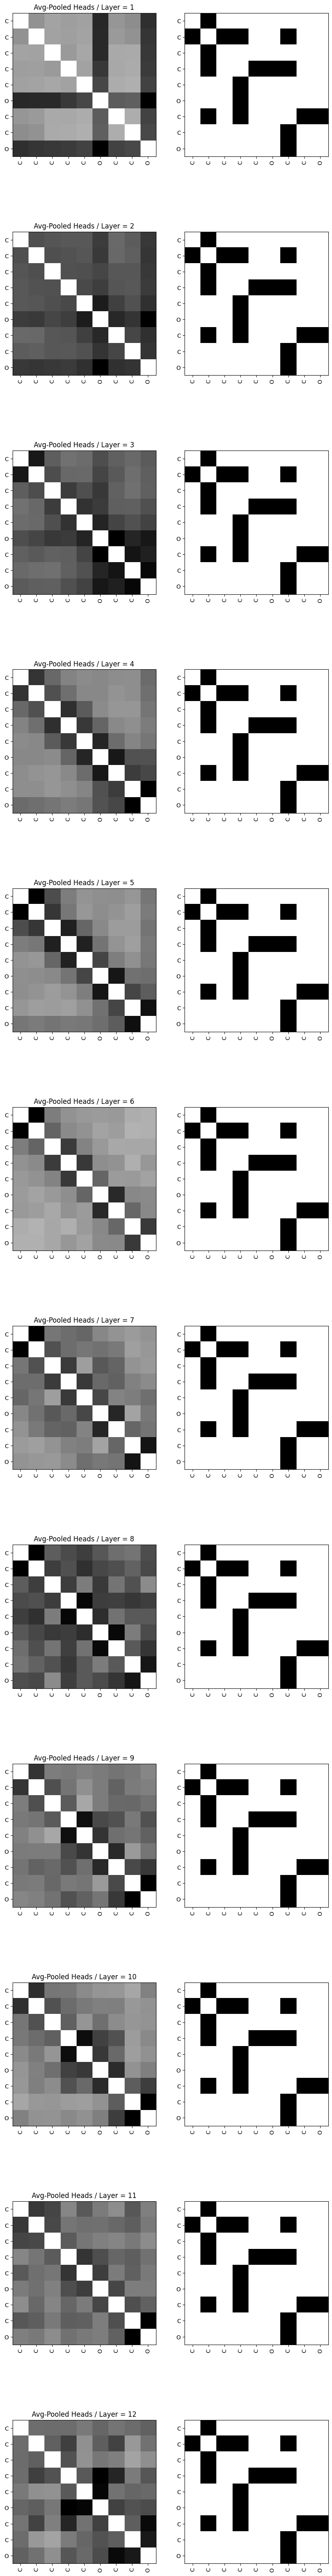

In [149]:
# Resolving Asymmetric Attentions + Avg Pooling

bonds_mat, gold_tokens = get_bonds_mat(sequence)
f, axarr = plt.subplots(12,2,figsize=(10,100))

ignore_tokens = ["(", ")", "=", ""]
ignore_tokens += ["1", "2",]
ignore_tokens += ["<eos>", "<bos>"]

for layer_idx in range(len(attentions)):
    some_layer = attentions[layer_idx].squeeze()
    tensor = torch.mean(some_layer, dim=0)
    
    tensor = ((tensor+torch.transpose(tensor, 0, 1))/2).cpu()
    tensor.fill_diagonal_(0.0)
    tensor = tensor.numpy()
    
    tensor, filtered_tokens = filter_unwanted_tokens(tensor, tokens, ignore_tokens)
    
    axarr[layer_idx,0].imshow(tensor, cmap='binary', interpolation='none', aspect='equal')
    axarr[layer_idx,1].imshow(bonds_mat, cmap='binary', interpolation='none', aspect='equal')
    

    axarr[layer_idx,0].set_xticks(range(0, len(filtered_tokens)))
    axarr[layer_idx,0].set_yticks(range(0, len(filtered_tokens)))

    axarr[layer_idx,1].set_xticks(range(0, len(gold_tokens)))
    axarr[layer_idx,1].set_yticks(range(0, len(gold_tokens)))

    axarr[layer_idx,0].set_yticklabels(filtered_tokens)
    axarr[layer_idx,0].set_xticklabels(filtered_tokens, rotation='vertical')

    axarr[layer_idx,1].set_yticklabels(gold_tokens)
    axarr[layer_idx,1].set_xticklabels(gold_tokens, rotation='vertical')

    axarr[layer_idx,0].set_title(f"Avg-Pooled Heads / Layer = {layer_idx+1}")

plt.subplots_adjust(hspace=-0.7)
plt.show()
# Uncomment this if you want to save FIGURES
#plt.savefig(f'figs/rot_linear_seq{seq_idx}_filtered_no_numeric_no_beos.png', bbox_inches='tight') 

### The following plots corresponds to Figure 8 & 9 in appendix

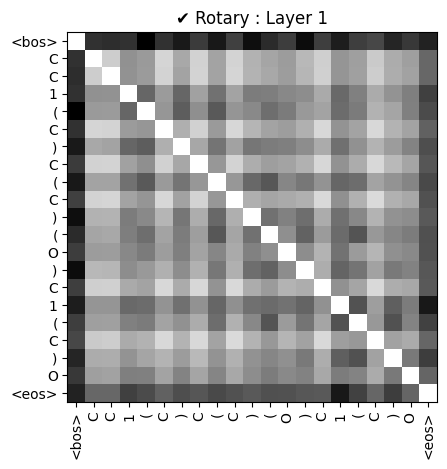

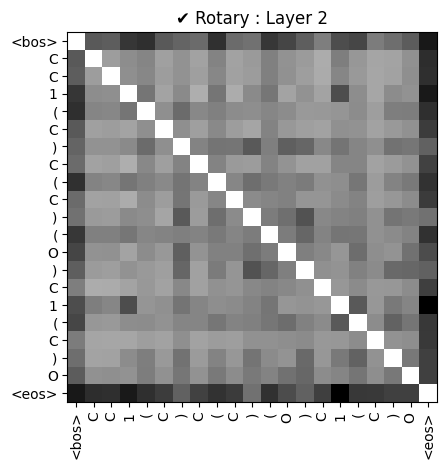

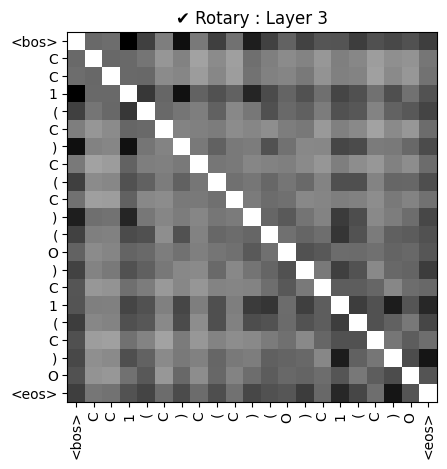

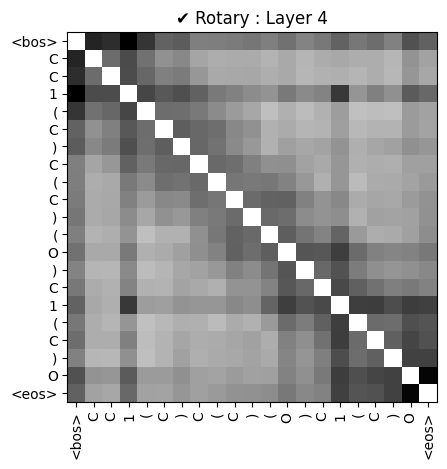

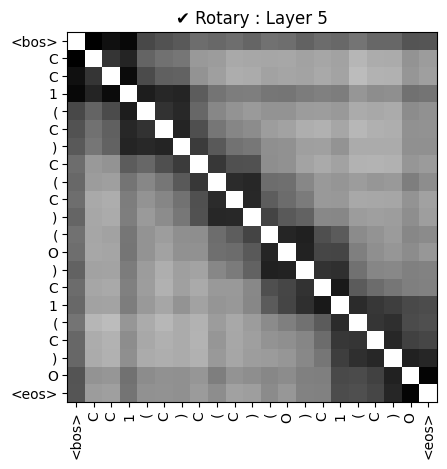

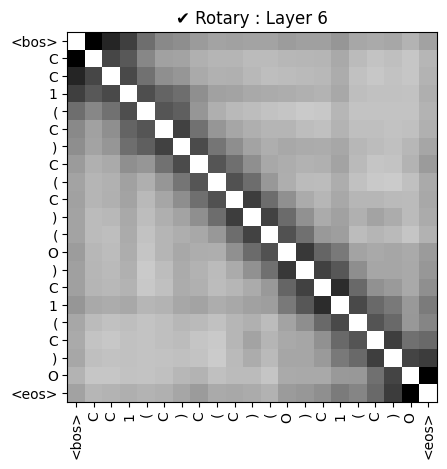

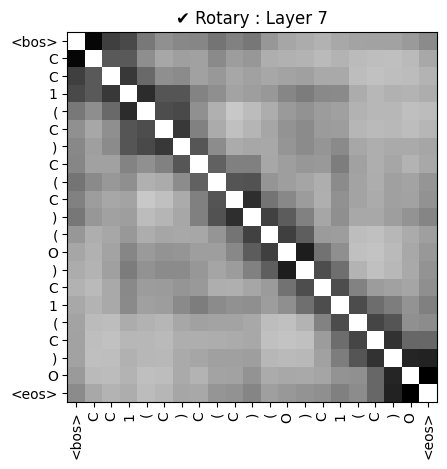

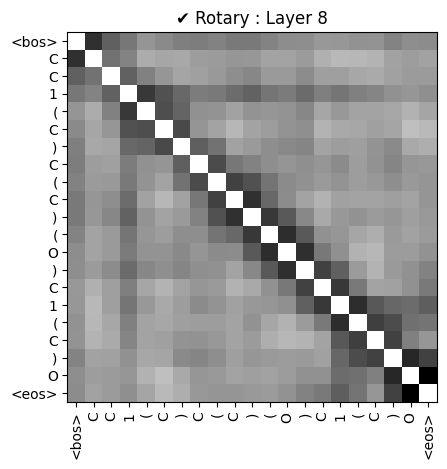

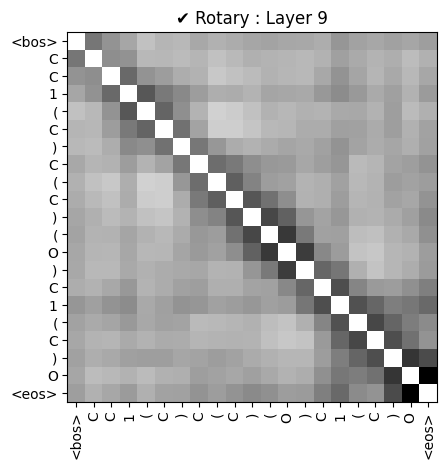

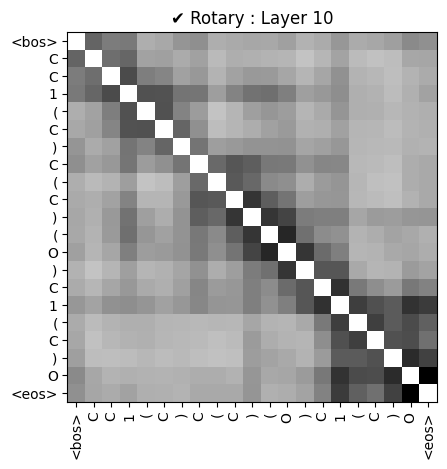

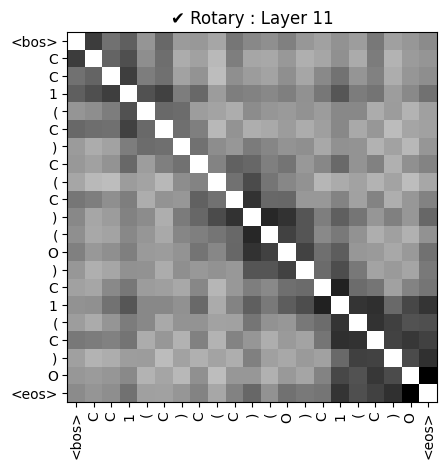

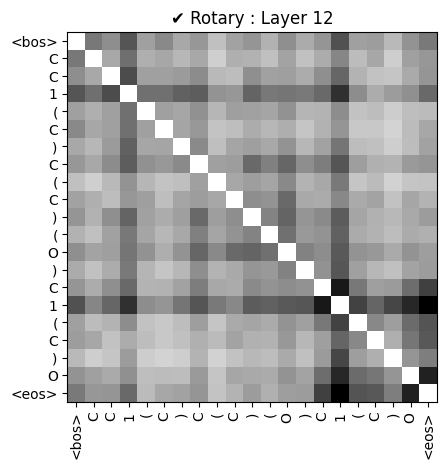

In [125]:
# Plot for Appendix

attentions, tokens = get_full_attention(sequence, model, defaults, tokenizer)
bonds_mat, gold_tokens = get_bonds_mat(sequence)

ignore_tokens = []
for layer_idx in range(len(attentions)):
    some_layer = attentions[layer_idx].squeeze()
    tensor = torch.mean(some_layer, dim=0)
    
    tensor = ((tensor+torch.transpose(tensor, 0, 1))/2).cpu()
    tensor.fill_diagonal_(0.0)
    tensor = tensor.numpy()
    
    tensor, filtered_tokens = filter_unwanted_tokens(tensor, tokens, ignore_tokens)
    
    plt.imshow(tensor, cmap='binary', interpolation='none', aspect='equal')

    plt.xticks(range(0, len(filtered_tokens)), filtered_tokens, rotation='vertical')
    plt.yticks(range(0, len(filtered_tokens)), filtered_tokens)

    plt.title(f"\u2714 Rotary : Layer {layer_idx+1}")
    plt.show()

    # Uncomment this if you want to save FIGURES
    #plt.savefig(f'figs/appendix_rot_linear_seq{seq_idx}_layer{layer_idx}.png', bbox_inches='tight', dpi=200)  

### The following plots corresponds to Figure 4 in main paper

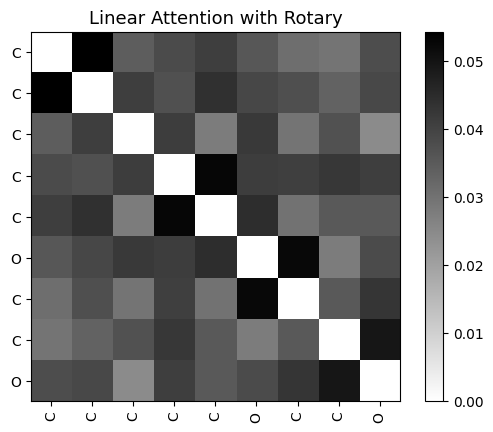

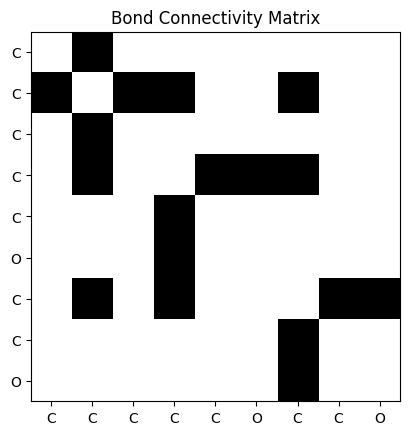

[16:07:16] Molecule does not have explicit Hs. Consider calling AddHs()


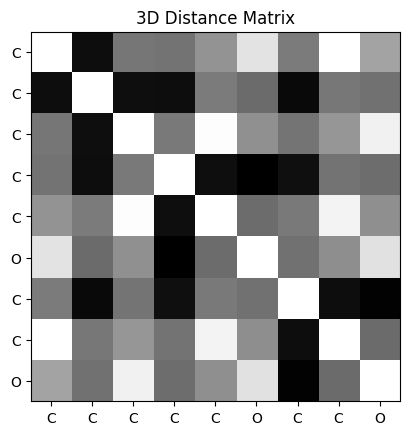

In [126]:
layer_idx = 7
ignore_tokens = ["(", ")", "=", ""]
ignore_tokens += ["1", "2",]
ignore_tokens += ["<eos>", "<bos>"]

bonds_mat, bonds_tokens = get_bonds_mat(sequence)
some_layer = attentions[layer_idx].squeeze()
tensor = torch.mean(some_layer, dim=0)   
tensor = ((tensor+torch.transpose(tensor, 0, 1))/2).cpu()
tensor.fill_diagonal_(0.0)
tensor = tensor.numpy()
tensor, filtered_tokens = filter_unwanted_tokens(tensor, tokens, ignore_tokens)

plt.imshow(tensor, cmap='binary', interpolation='none', aspect='equal')
plt.xticks(range(0, len(filtered_tokens)),filtered_tokens, rotation='vertical')
plt.yticks(range(0, len(filtered_tokens)),filtered_tokens)
plt.colorbar()
plt.title(f"Linear Attention with Rotary", fontsize=13)
# Uncomment this if you want to save FIGURES
#plt.savefig(f'figs/rotary_linear_l{layer_idx}_attention_seq{seq_idx}.png', bbox_inches='tight', dpi=200) 
plt.show()


plt.imshow(bonds_mat, cmap='binary', interpolation='none', aspect='equal')
plt.xticks(range(0, len(bonds_tokens)),bonds_tokens)
plt.yticks(range(0, len(bonds_tokens)),bonds_tokens)
plt.title(f"Bond Connectivity Matrix")
# Uncomment this if you want to save FIGURES
#plt.savefig(f'figs/bond_seq{seq_idx}.png', bbox_inches='tight', dpi=200)
plt.show()


mol = Chem.MolFromSmiles(sequence)
confid = AllChem.EmbedMolecule(mol)
dist_matrix = rdmolops.Get3DDistanceMatrix(mol, confId=confid)
np.fill_diagonal(dist_matrix, np.nan)
plt.imshow(dist_matrix, cmap='gist_gray', interpolation='none', aspect='equal')
plt.xticks(range(0, len(bonds_tokens)),bonds_tokens)
plt.yticks(range(0, len(bonds_tokens)),bonds_tokens)
#plt.colorbar()
# Uncomment this if you want to save FIGURES
plt.title(f"3D Distance Matrix")
#plt.savefig(f'figs/3d_distance_seq{seq_idx}.png', bbox_inches='tight', dpi=200)
plt.show()
